In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.circuit.library import IntegerComparator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeMontreal, FakeMumbai, FakeGuadalupe, FakeToronto, FakeCasablanca
from qiskit.providers.aer import QasmSimulator 
from qiskit.circuit.library import LinearAmplitudeFunction

account = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# idea: reset the qubits representing the distribution(s)

In [2]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]

# def sett(daf, i):
#     return daf.iloc[i]['sett']

# assets = ['613108_581', '005109_41492']

df = df.iloc[[38-2, 260-2, 7816-2]] 

In [3]:
F = pd.read_csv("F_for_sampled_counterparts.csv")

sectors = [1-1, 2-1]
F_values = [[F.iloc[df.index.values[j]][i] for i in sectors] for j in range(len(df))]
alphas_list = [[0.35, 0.2], [0.1, 0.25]] # make F/rhos

In [4]:
# Build noise model from backend properties
fake_backend = FakeGuadalupe()

# set problem parameters
n_z = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)

# clusters 1118 e 1618  
p_zeros = [0.15, 0.25] #[el['pd'] for _, el in df.iterrows()]                                                             #[0.15, 0.25, 0.2]
rhos = [0.1, 0.05] #[el['is']**2 for _, el in df.iterrows()]    #not the same as the paper                                 #[0.1, 0.05, 0.2]
lgd = [1000.5, 2000.5] #[el['lgd dwt']*el['ead'] for _, el in df.iterrows()] # = [425701.9399312228, 3376.692855]           #[1, 1, 1] [0.67, 0.49] 

K = len(p_zeros)

n_shots = 2048
optimization_level = 1
alpha_var = 0.05

print(f'F: {alphas_list}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
# df

F: [[0.35, 0.2], [0.1, 0.25]]
Rhos: [0.31622777 0.2236068 ]
Lgds: [1000.5, 2000.5]
p_zeros: [0.15, 0.25]


In [5]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019, 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""Multivariate Gaussian Conditional Independence Model for Credit Risk."""

from typing import List, Union
import numpy as np
from scipy.stats.distributions import norm

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import LinearPauliRotations
from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library.generalized_gates import mcmt


class MultivariateGCI(QuantumCircuit):
    """Attempt for a multivariate Gaussian Conditional 
    Independence Model for Credit Risk.
    """


    def __init__(
        self,
        n_normal: int,
        normal_max_value: float,
        p_zeros: Union[List[float], np.ndarray],
        rhos: Union[List[float], np.ndarray],
        alphas_list: List[float],
    ) -> None:
        """
        Args:
            n_normal: Number of qubits to represent the latent normal random variable Z
            normal_max_value: Min/max value to truncate the latent normal random variable Z
            p_zeros: Standard default probabilities for each asset
            rhos: Sensitivities of default probability of assets with respect to latent variable Z
        """
        self.n_normal = n_normal
        self.normal_max_value = normal_max_value
        self.p_zeros = p_zeros
        self.rhos = rhos
        num_qubits = n_normal*len(sectors) + len(p_zeros)

        # get normal (inverse) CDF and pdf (these names are from the paper, therefore ignore
        # pylint)
        def F(x):  # pylint: disable=invalid-name
            return norm.cdf(x)

        def F_inv(x):  # pylint: disable=invalid-name
            return norm.ppf(x)

        def f(x):  # pylint: disable=invalid-name
            return norm.pdf(x)

        # create linear rotations for conditional defaults
        slopes = []
        offsets = []
        for rho, p_zero, alphas in zip(rhos, p_zeros, alphas_list):
            psi = F_inv(p_zero) / np.sqrt(1 - rho) 
            # compute slope / offset
            slope_list = []
            case=[]
            for i in range(len(sectors)):
                slope = -np.sqrt(rho)*alphas[i] / np.sqrt(1 - rho) #-alphas[i] / np.sqrt(1 - rho) #
                slope *= f(psi) / np.sqrt(1 - F(psi)) / np.sqrt(F(psi))
                slope_list.append(slope)
            
            offset = 2 * np.arcsin(np.sqrt(F(psi)))
            #print(offset)

            # adjust for integer to normal range mapping
            for i in range(len(sectors)):
                offset += slope_list[i] * (-normal_max_value)
                slope_list[i] *= 2 * normal_max_value / (2 ** n_normal - 1)

            offsets += [offset]
            slopes += [slope_list]
            
        # create normal distributions        
        normal_distributions = []
        for i in range(len(sectors)):
            dist = NormalDistribution(
                        n_normal,
                        0,
                        1, 
                        bounds=(-normal_max_value, normal_max_value)
                    )
            normal_distributions.append(dist)

        # build circuit
        inner = QuantumCircuit(num_qubits, name="P(X)")
        #inner.append(normal_distribution.to_gate(), list(range(n_normal*2)))
        for i, el in enumerate(normal_distributions):
            inner.append(el.to_gate(), list(range(i*n_normal,(i+1)*n_normal)))
        #inner.draw()

        for k, (slope, offset) in enumerate(zip(slopes, offsets)):
            #lry = LinearPauliRotations(n_normal, slope, offset)
            for i in range(len(sectors)):
                if i == 0:
                    lry = LinearPauliRotations(n_normal, slope[i], offset)
                else:
                    lry = LinearPauliRotations(n_normal, slope[i], 0) 
                qubits = list(range(i*n_normal,(i+1)*n_normal)) + [n_normal*len(sectors) + k]
            
                inner.append(lry.to_gate(), qubits)

        super().__init__(num_qubits, name="P(X)")
        self.append(inner.to_gate(), inner.qubits)

In [6]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019, 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""The Gaussian Conditional Independence Model for Credit Risk."""

from typing import List, Union
import numpy as np
from scipy.stats.distributions import norm

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import LinearPauliRotations
from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import WeightedAdder


class MultivariateGCI_woerner(QuantumCircuit):
    """The Gaussian Conditional Independence Model for Credit Risk.
    Reference: https://arxiv.org/abs/1412.1183
    Dependency between individual risk variables and latent variable is approximated linearly.
    """

    def __init__(
        self,
        n_normal: int,
        normal_max_value: float,
        p_zeros: Union[List[float], np.ndarray],
        rhos: Union[List[float], np.ndarray],
        alphas: List[float],
    ) -> None:
        """
        Args:
            n_normal: Number of qubits to represent the latent normal random variable Z
            normal_max_value: Min/max value to truncate the latent normal random variable Z
            p_zeros: Standard default probabilities for each asset
            rhos: Sensitivities of default probability of assets with respect to latent variable Z
        """
        self.n_normal = n_normal
        self.normal_max_value = normal_max_value
        self.p_zeros = p_zeros
        self.rhos = rhos
        num_qubits = n_normal*len(alphas) + len(p_zeros)

        # get normal (inverse) CDF and pdf (these names are from the paper, therefore ignore
        # pylint)
        def F(x):  # pylint: disable=invalid-name
            return norm.cdf(x)

        def F_inv(x):  # pylint: disable=invalid-name
            return norm.ppf(x)

        def f(x):  # pylint: disable=invalid-name
            return norm.pdf(x)

        # create linear rotations for conditional defaults
        slopes = []
        offsets = []
        for rho, p_zero in zip(rhos, p_zeros):
            psi = F_inv(p_zero) / np.sqrt(1 - rho)

            # compute slope / offset
            slope = -np.sqrt(rho) / np.sqrt(1 - rho) #-1 / np.sqrt(1 - rho) 
            offset = 2 * np.arcsin(np.sqrt(F(psi)))
            slope *= f(psi) / np.sqrt(1 - F(psi)) / np.sqrt(F(psi))
            

            # adjust for integer to normal range mapping
            offset += slope * (-normal_max_value) * len(alphas)
            slope *= 2 * normal_max_value / (2 ** n_normal - 1)

            offsets += [offset]
            slopes += [slope]

        # create multivariate normal distribution
        normal_distribution = NormalDistribution(
            list(np.zeros(len(alphas), dtype=int)+n_z),
            list(np.zeros(len(alphas), dtype=int)),
            np.diag(np.array(alphas)**2), 
            bounds=[(-normal_max_value, normal_max_value) for i in range(len(alphas))],
        )

        # create WeightedAdder
        weights = []
        for n in [n_normal]*len(alphas):
            for i in range(n):
                weights += [2**i]
        Y_risk = WeightedAdder(n_normal*len(alphas), weights) 
        #print(Y_risk.num_sum_qubits)

        # build circuit
        non_state_qubits = Y_risk.num_sum_qubits+Y_risk.num_carry_qubits+Y_risk.num_control_qubits
        inner = QuantumCircuit(num_qubits+non_state_qubits, name="P(X)")
        inner.append(normal_distribution.to_gate(), list(range(n_normal*len(alphas))))
        inner.append(Y_risk.to_gate(), list(range(n_normal*len(alphas)+non_state_qubits)))

        for k, (slope, offset) in enumerate(zip(slopes, offsets)):
            lry = LinearPauliRotations(Y_risk.num_sum_qubits, slope, offset)
            qubits = list(range(Y_risk.num_state_qubits, Y_risk.num_state_qubits+Y_risk.num_sum_qubits)) + [Y_risk.num_qubits + k]
            inner.append(lry.to_gate(), qubits)

        super().__init__(num_qubits+non_state_qubits, name="P(X)")
        self.append(inner.to_gate(), inner.qubits)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=1.0em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{1}{\mathrm{P(X)}}_<<<{0} & \multigate{4}{\mathrm{LinRot}}_<<<{0} & \qw & \multigate{5}{\mathrm{LinRot}}_<<<{0} & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{P(X)}}_<<<{1} & \ghost{\mathrm{LinRot}}_<<<{1} & \qw & \ghost{\mathrm{LinRot}}_<<<{1} & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \multigate{1}{\mathrm{P(X)}}_<<<{0} & \ghost{\mathrm{LinRot}} & \multigate{2}{\mathrm{LinRot}}_<<<{0} & \ghost{\mathrm{LinRot}} & \multigate{3}{\mathrm{LinRot}}_<<<{0} & \qw & \qw\\
	 	\nghost{{q}_{3} :  } & \lstick{{q}_{3} :  } & \ghost{\mathrm{P(X)}}_<<<{1} & \ghost{\mathrm{LinRot}} & \ghost{\mathrm{LinRot}}_<<<{1} & \ghost{\mathrm{LinRot}} & \ghost{\mathrm{LinRot}}_<<<{1} & \qw & \qw\\
	 	\nghost{{q}_{4} :  } & \lsti

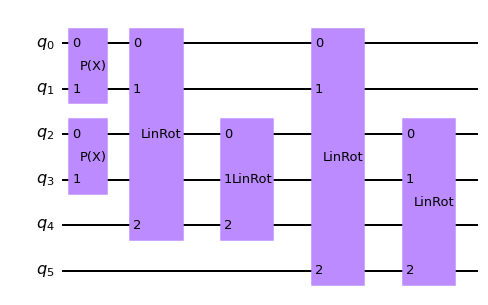

In [7]:
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

if len(sectors) == 1:
    u = GCI(n_z, z_max, p_zeros, rhos)
else:
    # u = MultivariateGCI_woerner(n_z, z_max, p_zeros, rhos, alphas_list[1])
    u = MultivariateGCI(n_z, z_max, p_zeros, rhos, alphas_list)
# u.decompose().decompose().decompose().decompose().decompose().draw(filename='u_circuit.svg', fold=22)
print(u.decompose().draw(output='latex_source'))
u.decompose().draw(filename='u_circuit.svg', fold=22)

In [8]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend('statevector_simulator'), n_shots=n_shots)

# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(np.array(job.result().get_statevector())):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2
    
    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha_var)
exact_var = losses[i_var]

print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L]:              %.4f' % exact_var)

Expected Loss E[L]:                628.2038
Value at Risk VaR[L]:              2000.5000


In [9]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    #print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    #print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0

In [11]:
depth = 'full'

if depth == 'e_loss':
    # define linear objective function for expected loss
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    offsets = [mapping(el) for el in breakpoints]
    f_min = 0
    f_max = sum(lgd)
    c_approx = 0.01

    objective_e_loss = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

Operator CDF(3001) = 1.0000


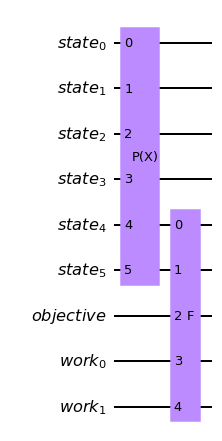

In [17]:
from qiskit.circuit.library import LinearAmplitudeFunction


def get_cdf_circuit(x_eval):
    
    # define linear objective function for cdf
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    # print(values)
    offsets = [1 if mapping(el)<=x_eval else 0 for el in breakpoints]
    f_min = 0
    f_max = 1
    c_approx = 0.01
    
    objective = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    # linear objective function (does aggregation and comparison)
    if depth == 'e_loss':
        state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective_e_loss
    else:
        state_preparation.append(objective.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective
    
example = 3001
state_preparation, objective = get_cdf_circuit(example)
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'), shots=2048)

# evaluate resulting statevector
var_prob = 0
for i, a in enumerate(np.array(job.result().get_statevector())):
    b = ('{0:0%sb}' % (u.num_qubits + 1)).format(i)[-(u.num_qubits + 1):]
    prob = np.abs(a)**2
    if b[0] == '1':
        var_prob += prob
if depth == 'e_loss':
    print('Operator Expected Loss' + ' = %.4f' % objective.post_processing(var_prob))
else:
    print('Operator CDF(%s)' % example + ' = %.4f' % objective.post_processing(var_prob))
state_preparation.draw()

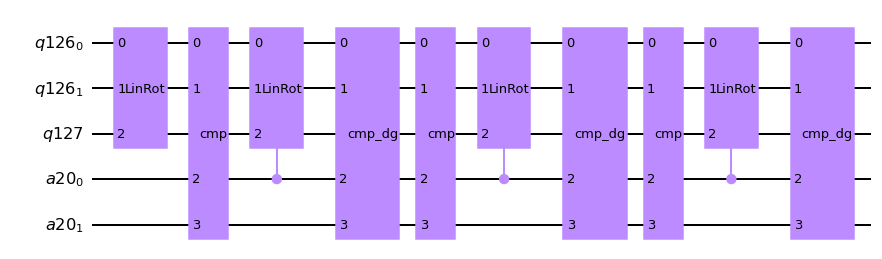

In [20]:
objective.decompose().decompose().draw() #scales as 2^K-1

In [75]:
import time
# set target precision and confidence level
epsilon = 0.002 #0.01
alpha = 0.01 #0.05

device = QasmSimulator.from_backend(fake_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

qi_ideal = QuantumInstance(Aer.get_backend('aer_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)

# qi_noise = QuantumInstance(provider.get_backend('ibm_perth'), shots=n_shots, 
#                             optimization_level=optimization_level, seed_transpiler=42)

qi_noise = QuantumInstance(QasmSimulator.from_backend(fake_backend), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)

In [76]:
depth = 'e_loss'
if depth == 'e_loss':
    start_time = time.time()
    problem = EstimationProblem(state_preparation=state_preparation,
                                objective_qubits=[u.num_qubits],
                                post_processing=objective.post_processing)
    # construct amplitude estimation 
    ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_ideal)
    result = ae.estimate(problem)
    q_samples_ideal = 2**len(result.powers)-1
    # save results
    conf_int_ideal = np.array(result.confidence_interval_processed)
    result_ideal = result.estimation_processed
    runtime_ideal = time.time() - start_time
    ideal_result = result

    print("result with no noise:", result_ideal)

#     start_time = time.time()
#     problem = EstimationProblem(state_preparation=state_preparation,
#                                 objective_qubits=[u.num_qubits],
#                                 post_processing=objective.post_processing)
#     # construct amplitude estimation
#     ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_noise)
#     result = ae.estimate(problem)
#     q_samples_noisy = 2**len(result.powers)-1

#     # print results
#     conf_int_noisy = np.array(result.confidence_interval_processed)
#     result_noisy = result.estimation_processed
#     runtime_noisy = time.time() - start_time
#     noisy_result = result
    
#     print("\nresult with noise:", result_noisy)

result with no noise: 645.33802437919


293116
362333


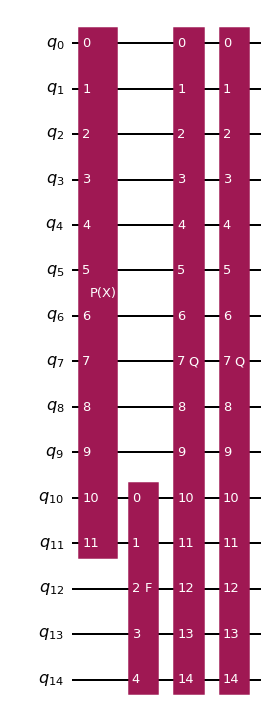

In [77]:
from qiskit import transpile
from qiskit.visualization import plot_circuit_layout

ae_circuit = ae.construct_circuit(problem, k=2)
tr_ae_circuit = transpile(ae_circuit, optimization_level=optimization_level, backend=fake_backend, seed_transpiler=42)
print(tr_ae_circuit.depth()) # Return circuit depth (i.e., length of critical path).
print(tr_ae_circuit.size()) # Returns total number of instructions in circuit.

# noise_model = NoiseModel.from_backend(QasmSimulator.from_backend(fake_backend))
# basis_gates = noise_model.basis_gates
# tr_ae_circuit = transpile(ae_circuit, basis_gates=basis_gates, optimization_level=optimization_level)

ae_circuit.decompose().draw("mpl", style="iqx")
#plot_circuit_layout(tr_ae_circuit, fake_backend)
# ae_circuit.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().size()

In [17]:
def run_ae_for_cdf(x_eval, epsilon=epsilon, alpha=alpha, simulator='aer_simulator', noise=False):

    # construct amplitude estimation 
    state_preparation, objective = get_cdf_circuit(x_eval)
    
    if noise == False:
        qi = QuantumInstance(Aer.get_backend('aer_simulator'), shots=n_shots, )
                               #optimization_level=optimization_level, seed_transpiler=42)
    else:
        qi = QuantumInstance(QasmSimulator.from_backend(fake_backend), shots=n_shots, )
                               #optimization_level=optimization_level, seed_transpiler=42)
        
    problem = EstimationProblem(state_preparation=state_preparation,
                                objective_qubits=[u.num_qubits])
    
    ae_var = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
    #ae_circuit = ae_var.construct_circuit(problem, k=50000, measurement=False)
    result_var = ae_var.estimate(problem)
    print(result_var.num_oracle_queries)
    
    return objective.post_processing(result_var.estimation)#, ae_circuit, result_var

In [26]:
cdf = [run_ae_for_cdf(el, epsilon=epsilon, alpha=alpha) for el in [0]+lgd+[np.sum(lgd)]] # not general!
print(cdf)

204800
20480
276480
18432
[0.6475004255444701, 0.7226032851979937, 0.9669731682100695, 1.011259526079844]


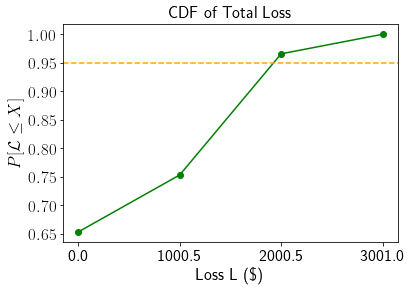

In [19]:
# plot loss CDF
plt.rcParams['text.usetex'] = True
plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')
plt.axhline(1-alpha_var, color="orange", linestyle="--")
   
plt.xlabel("Loss L (\$)", size=17)
plt.ylabel(r'$P[\mathcal{L} \leq X]$', size=17) 
plt.title ("CDF of Total Loss", size=17)
plt.xticks(np.sort(np.unique(losses)), np.sort(np.unique(losses)), size=17)
plt.yticks(size=17)
plt.savefig('cdf.svg', dpi=400, bbox_inches = "tight")
plt.show()

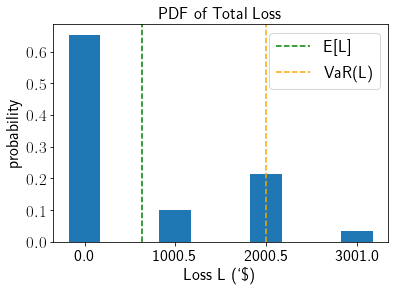

In [20]:
# plot loss PDF, expected loss, var, and evar
pdf = [el-np.sum(cdf[i-1:i]) for i, el in enumerate(cdf)]
plt.bar(np.sort(np.unique(losses)), pdf, align = "center", width = 350)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]") 
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
 
plt.legend(fontsize=17)
plt.xlabel("Loss L (`\$)", size=17)
plt.ylabel("probability", size=17)
plt.title ("PDF of Total Loss", size=17)
plt.xticks(np.sort(np.unique(losses)), np.sort(np.unique(losses)), size=17)
plt.yticks(size=17)
plt.savefig('pdf.svg', dpi=300, bbox_inches = "tight")
plt.show()

In [21]:
def bisection_search(objective, target_value, low_level, high_level, low_value=None, high_value=None):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print('--------------------------------------------------------------------')
    print('start bisection search for target value %.3f' % target_value)
    print('--------------------------------------------------------------------')
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1    
        
    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif low_value == target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'success'}

    # check if high_value is above target
    if high_value < target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif high_value == target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

    # perform bisection search until
    print('low_level    low_value    level    value     high_level    high_value')
    print('--------------------------------------------------------------------')
    while high_level - low_level > 0.1:

        level = (high_level + low_level) / 2.0
        num_eval += 1
        value = objective(level)

        print('%.2f     %.3f      %.2f   %.3f      %.2f       %.3f' \
              % (low_level, low_value, level, value, high_level, high_value))

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print('--------------------------------------------------------------------')
    print('finished bisection search')
    print('--------------------------------------------------------------------')
    return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

In [ ]:
# run bisection search to determine VaR

objective_ideal = lambda x: run_ae_for_cdf(x)
objective_noisy = lambda x: run_ae_for_cdf(x, noise=True)

bisection_result_ideal = bisection_search(objective_ideal, 1-alpha_var, min(losses)-0.001, max(losses), low_value=0, high_value=1)
# bisection_result_noisy = bisection_search(objective_noisy, 1-alpha, min(losses)-0.1, max(losses), low_value=0, high_value=1)

var = bisection_result_ideal['level']
# var_noisy = bisection_result_noisy['level']

print('Estimated Value at Risk: %.3f' % var)
# print('Estimated (w noise) Value at Risk: %.3f' % var_noisy)
print('Exact Value at Risk:     %.3f' % exact_var)
print('Estimated Probability:    %.3f' % bisection_result_ideal['value'])